[Caso Practico](https://drive.google.com/file/d/1uPzOMackxxcOpVlArik54AJV7VBz0y8D/view?usp=sharing)


*La empresa necesita saber que cliente es mas propenso a fugar.*

---

### Conexion Drive

In [397]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### Librerias

In [398]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')

In [399]:
# Para los graficos tengan las mismas dimensiones
%matplotlib inline
plt.style.use('ggplot')
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
#plt.rcParams['figure.figsize'] = (7, 4)

pd.options.display.max_columns = None
sns.set_style('whitegrid')
color = sns.color_palette()

## Rutas

In [400]:
#Repositorios
path = '/gdrive/MyDrive/BQ - Data Science/BQ - Repositorios/Repositorio_Portafolio/'
filename = "Churn-arboles.csv"
fullpath = os.path.join(path, filename)

# Lectura de datos

In [401]:
df = pd.read_csv(fullpath)

In [402]:
print(df.shape)
df.head(3)

(1345, 8)


,ID,EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO,CHURN
0,0,57,Femenino,Casado,2,27535.3,Si,Fuga
1,4,68,Femenino,Casado,2,81000.9,No,Fuga
2,8,34,Masculino,Soltero,0,87467.1,Si,No Fuga


# Data Wrangling

In [403]:
df = df.drop('ID',axis=1)

In [404]:
df.columns

Index(['EDAD', 'SEXO', 'CIVIL', 'HIJOS', 'INGRESO', 'AUTO', 'CHURN'], dtype='object')

In [405]:
df.dtypes

EDAD         int64
SEXO        object
CIVIL       object
HIJOS        int64
INGRESO    float64
AUTO        object
CHURN       object
dtype: object

In [406]:
columnas_categoricas = ['SEXO','CIVIL','AUTO','CHURN']
columnas_numericas = ['EDAD','HIJOS','INGRESO']

In [407]:
df.duplicated().any()

False

In [408]:
# Validando registros únicos
print(df.shape)
print(df.nunique())

(1345, 7)
EDAD         80
SEXO          2
CIVIL         2
HIJOS         3
INGRESO    1315
AUTO          2
CHURN         2
dtype: int64


## Tratamiento de Nulos

In [409]:
df.isnull().sum().sort_values(ascending=False)

EDAD       0
SEXO       0
CIVIL      0
HIJOS      0
INGRESO    0
AUTO       0
CHURN      0
dtype: int64

In [410]:
df.isnull().sum()/df.shape[0]*100

EDAD       0.0
SEXO       0.0
CIVIL      0.0
HIJOS      0.0
INGRESO    0.0
AUTO       0.0
CHURN      0.0
dtype: float64

# **I. Analisis Exploratorio**

In [411]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
EDAD,1345.0,NaN,NaN,NaN,57.452788,22.707005,18.0,38.0,58.0,77.0,97.0
SEXO,1345,2,Femenino,673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CIVIL,1345,2,Casado,800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HIJOS,1345.0,NaN,NaN,NaN,0.991822,0.823262,0.0,0.0,1.0,2.0,2.0
INGRESO,1345.0,NaN,NaN,NaN,50640.712448,28354.407405,110.284,25863.8,50290.7,75004.5,99832.9
AUTO,1345,2,No,921,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHURN,1345,2,No Fuga,832,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Revision Objetivo

Porcentaje de Creditos Aprobados : 0.62
Porcentaje de Creditos Rechazados : 0.38


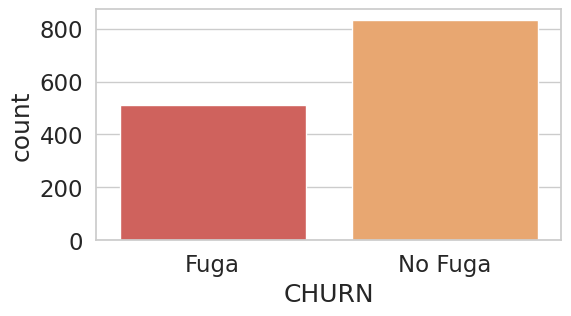

In [412]:
plt.figure(figsize=(6,3))
sns.countplot(x='CHURN', data=df);

print('Porcentaje de Creditos Aprobados : %.2f' % (df['CHURN'].value_counts()[0] / len(df)))
print('Porcentaje de Creditos Rechazados : %.2f' % (df['CHURN'].value_counts()[1] / len(df)))

## Analisis Univariado

### Categoricas

SEXO
Femenino     673
Masculino    672
dtype: int64


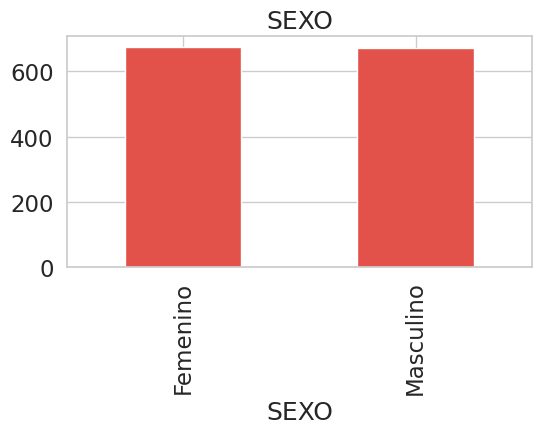

CIVIL
Casado     800
Soltero    545
dtype: int64


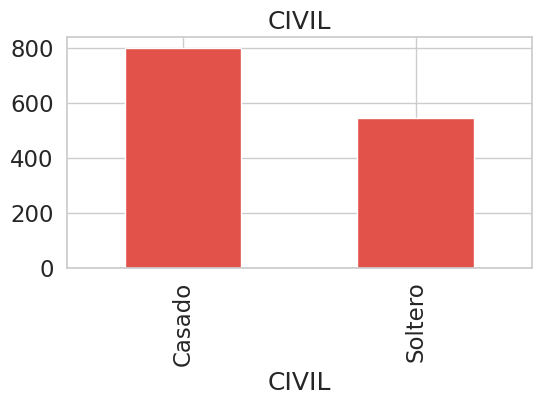

AUTO
No    921
Si    424
dtype: int64


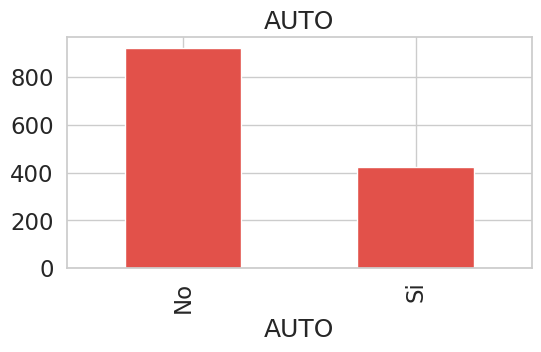

CHURN
Fuga       513
No Fuga    832
dtype: int64


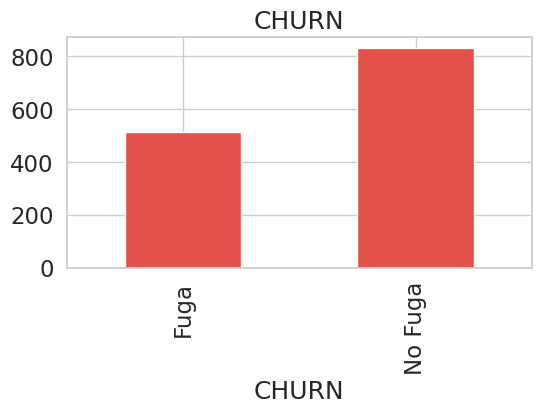

In [413]:
for x in columnas_categoricas:
  plt.figure(figsize=(6,3))
  print(df.groupby(x).size())
  plt.title(x)
  df.fillna("--NULL").groupby(x)[x].count().plot(kind = "bar")
  plt.show()

### Numericas

In [414]:
df[columnas_numericas].describe().T

,count,mean,std,min,25%,50%,75%,max
EDAD,1345.0,57.452788,22.707005,18.000,38.0,58.0,77.0,97.0
HIJOS,1345.0,0.991822,0.823262,0.000,0.0,1.0,2.0,2.0
INGRESO,1345.0,50640.712448,28354.407405,110.284,25863.8,50290.7,75004.5,99832.9


In [415]:
df.groupby('CHURN').median() # Mediana no se ve afectada con valores atípicos

,EDAD,HIJOS,INGRESO
CHURN,,,
Fuga,60.0,1.0,49553.9
No Fuga,56.0,1.0,52762.4


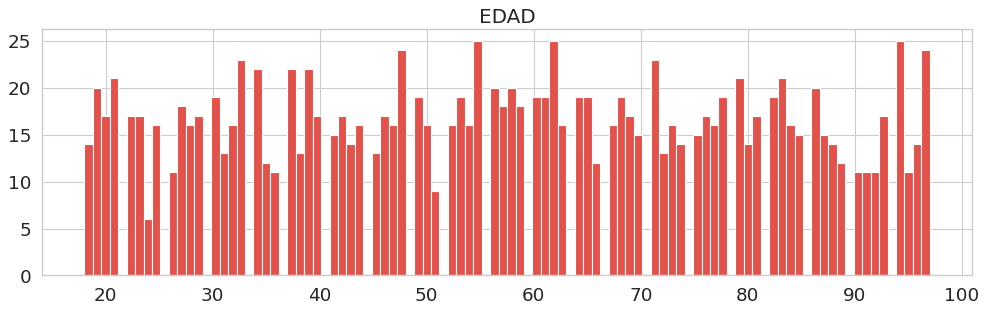

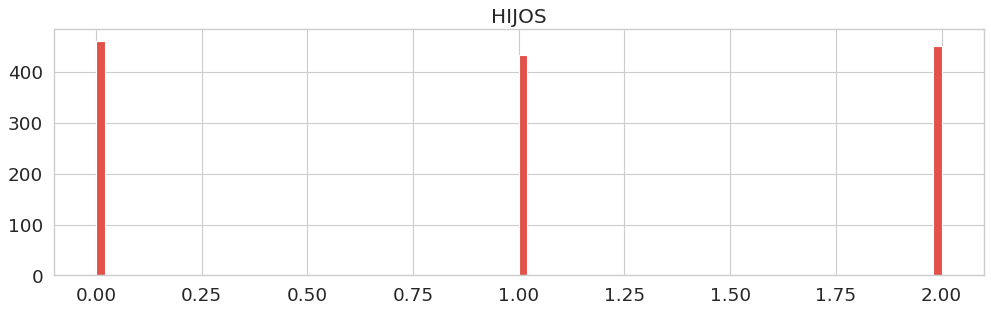

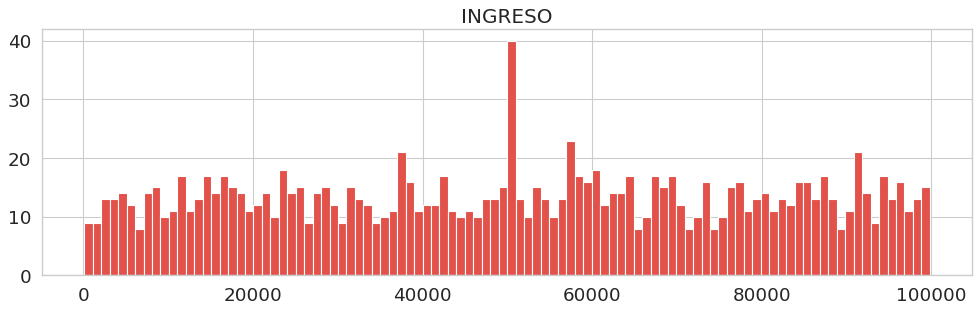

In [416]:
for x in columnas_numericas:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  plt.hist(df[x],bins=100)
  plt.show()

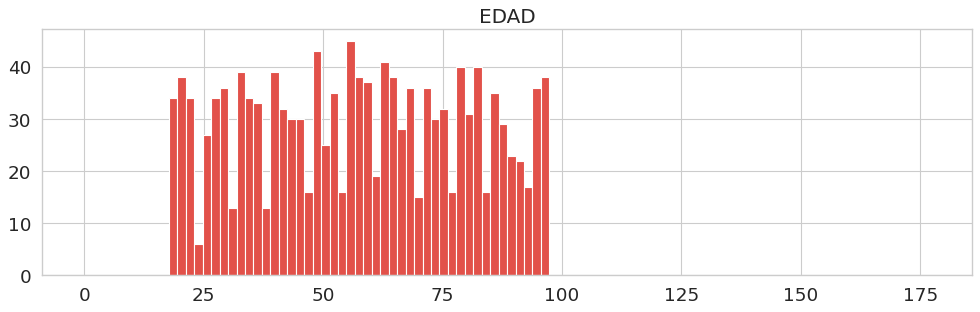

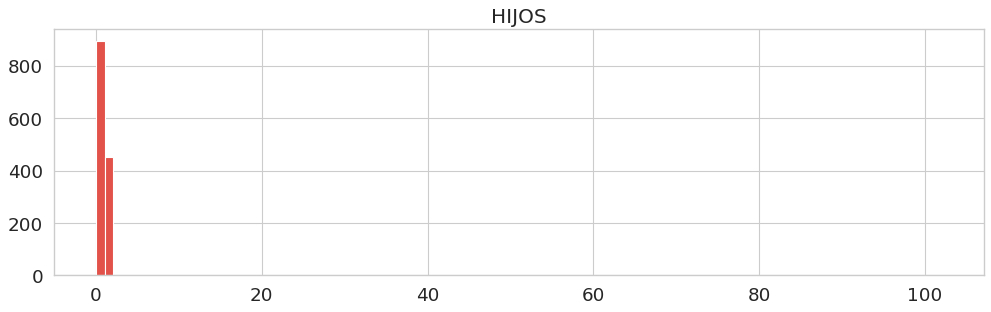

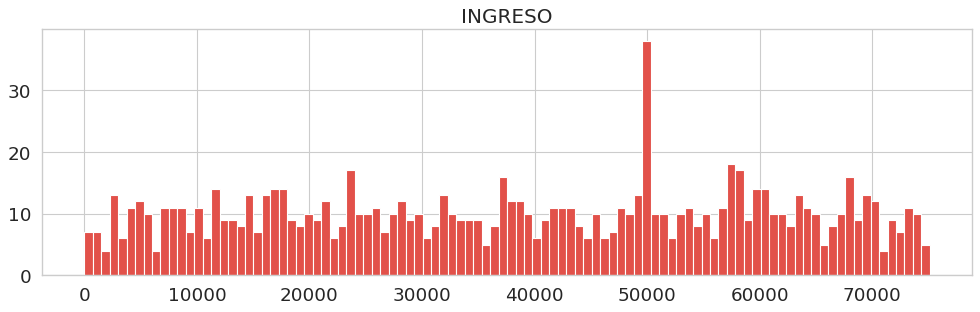

In [417]:
# No consideramos las colas (outliers) para ver mejor la distribucion
for x in columnas_numericas:
  plt.figure(figsize=(15,4), dpi=80)
  Q03= int(df[x].quantile(0.75))+100
  plt.title(df[x].name)
  plt.hist(df[x],bins=100,range=(0,Q03))
  plt.show()

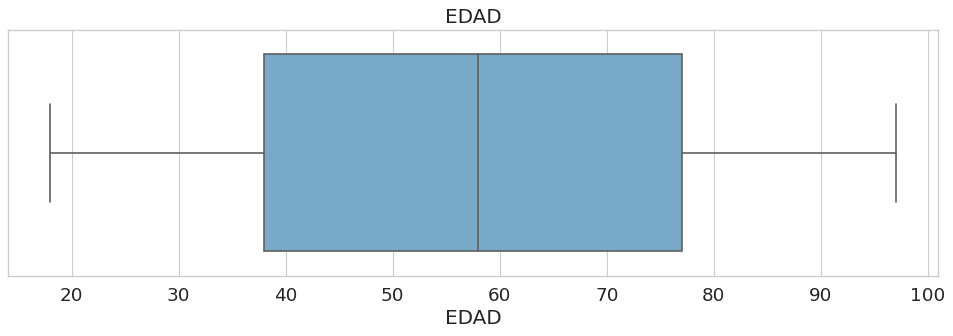

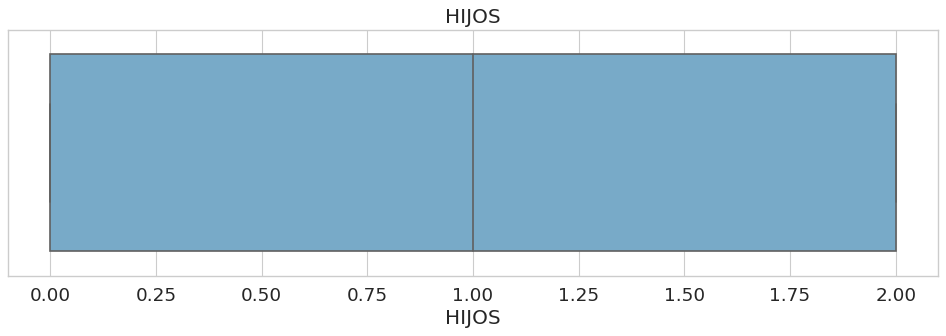

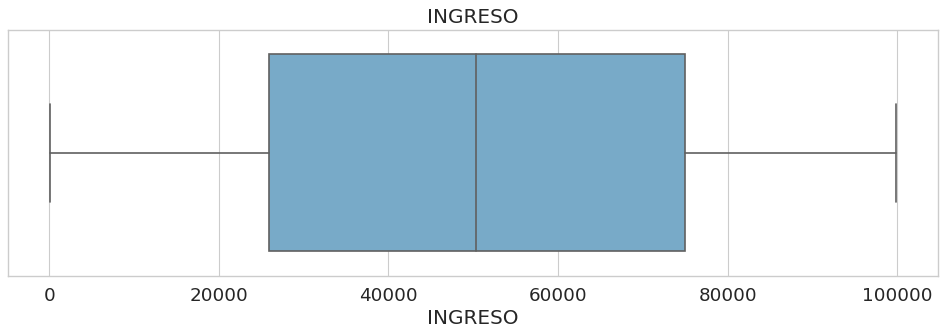

In [418]:
# Grafico de Cajas para revision de atipicos
for x in columnas_numericas:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  sns.boxplot(x=df[x], palette="Blues")
  plt.show()

## Anlisis Bivariado

### Categoricas

In [419]:
columnas_categoricas

['SEXO', 'CIVIL', 'AUTO', 'CHURN']

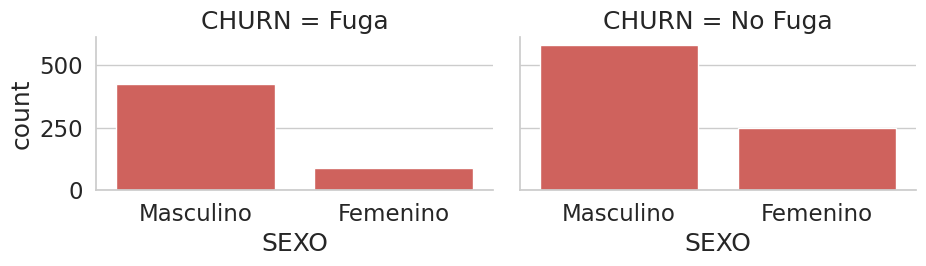

In [420]:
# SEXO

grid = sns.FacetGrid(df,col='CHURN', aspect=1.6)
grid.map(sns.countplot, 'SEXO');

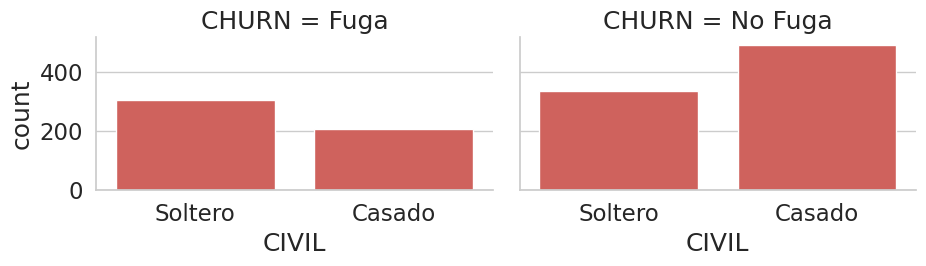

In [421]:
# CIVIL

grid = sns.FacetGrid(df,col='CHURN', aspect=1.6)
grid.map(sns.countplot, 'CIVIL');

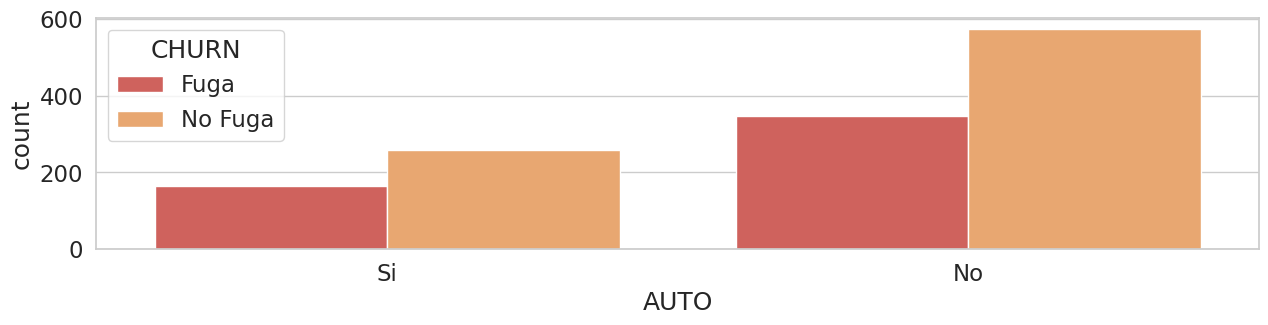

In [422]:
# AUTO

plt.figure(figsize=(15,3))
sns.countplot(x='AUTO', hue='CHURN', data=df);

### Numericas

EDAD


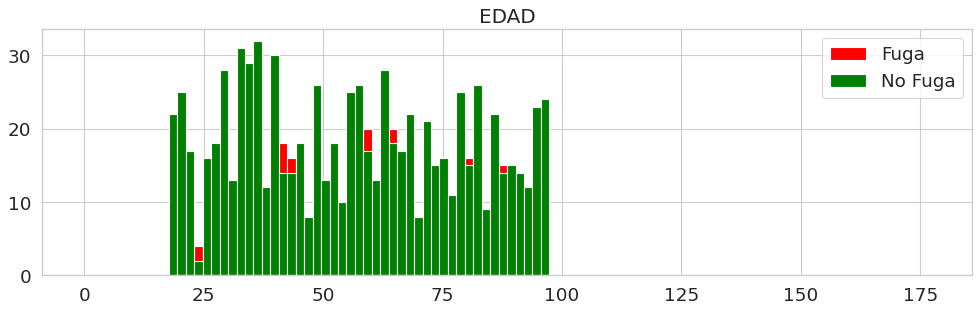

HIJOS


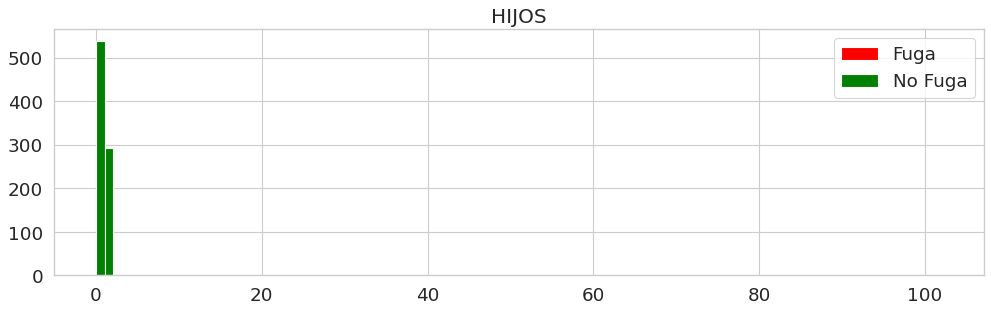

INGRESO


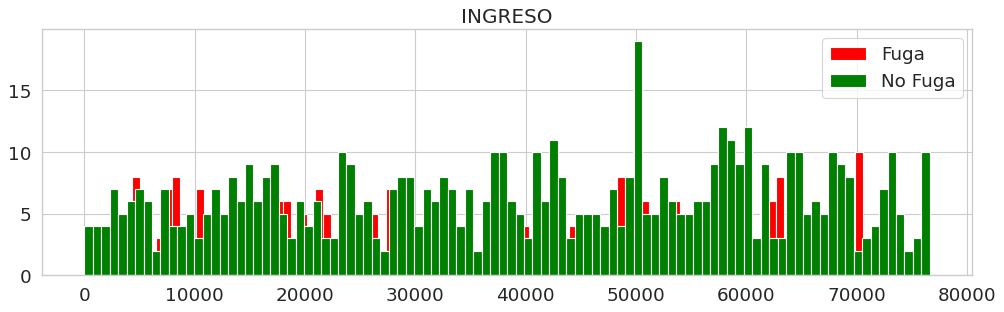

In [423]:
# Analizando variables numericas con respecto al target
for x in columnas_numericas:
  print(x)
  plt.figure(figsize=(15,4), dpi=80)
  x1 = df.loc[df['CHURN']=='Fuga',x]  #Serie
  x2 = df.loc[df['CHURN']=='No Fuga',x]  #serie

  Q03x1 = int(pd.DataFrame(x1)[x].quantile(0.75))+100  # Q3 de la serie
  Q03x2 = int(pd.DataFrame(x2)[x].quantile(0.75))+100  # Q3 de la serie

  #se muestran las densidades
  plt.title(df[x].name)
  plt.hist(x1,bins=100,color='r',range=(0,Q03x1),label='Fuga')
  plt.hist(x2,bins=100,color='g',range=(0,Q03x2),label='No Fuga')
  plt.legend()
  plt.show()

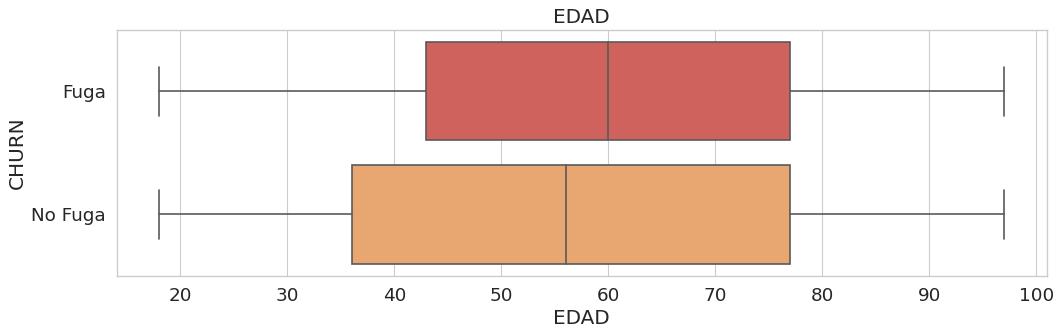

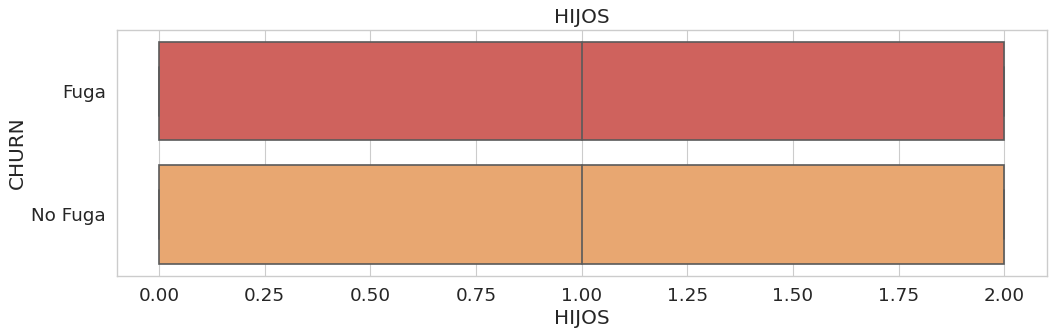

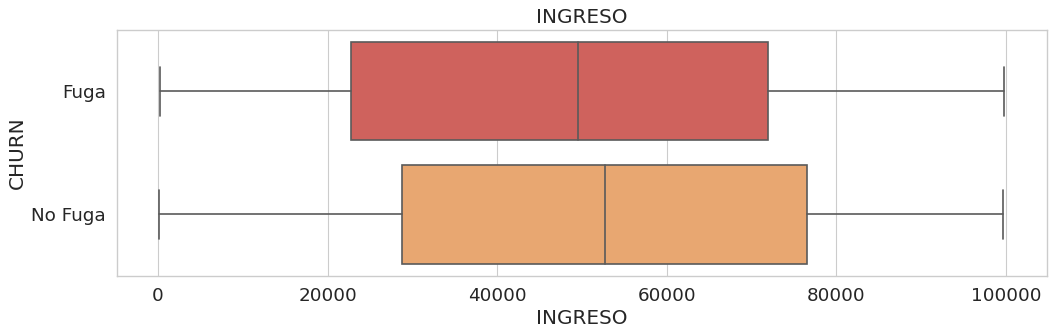

In [424]:
# Grafico de cajas respecto al target
for x in columnas_numericas:
  plt.figure(figsize=(15,4), dpi=80)
  plt.title(df[x].name)
  sns.boxplot(x=df[x],y=df['CHURN'])
  plt.show()

## Analisis Multivariado

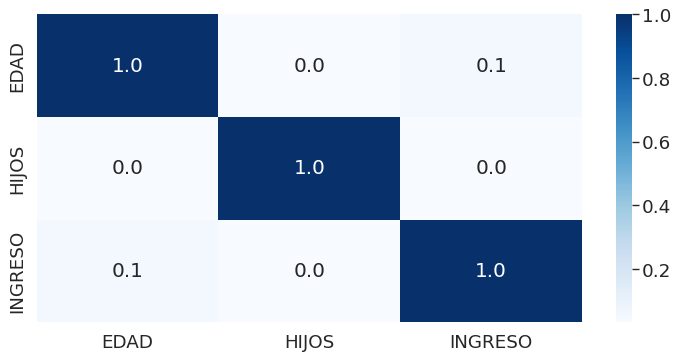

In [425]:
# Analizamos la correlacion de las variables
# Spearman: Para variables numericas. No asume normalidad
plt.figure(figsize=(11,5), dpi=80)
sns.heatmap(abs(df.corr(method='spearman')),annot=True,fmt='.1f',cmap='Blues')
plt.show()

#### Recodificacion Data

In [426]:
from sklearn.preprocessing import LabelEncoder

In [427]:
for c in columnas_categoricas:
  print(str(c))
  le = LabelEncoder()
  le.fit(df[str(c)])
  df[str(c)] = le.transform(df[str(c)])

SEXO
CIVIL
AUTO
CHURN


In [428]:
df.head(3)

,EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO,CHURN
0,57,0,0,2,27535.3,1,0
1,68,0,0,2,81000.9,0,0
2,34,1,1,0,87467.1,1,1


In [429]:
df['CHURN'].value_counts()

1    832
0    513
Name: CHURN, dtype: int64

In [430]:
df.dtypes

EDAD         int64
SEXO         int64
CIVIL        int64
HIJOS        int64
INGRESO    float64
AUTO         int64
CHURN        int64
dtype: object

# **II. Ingenieria de Variables**

In [431]:
df['Ingreso/hijo']=df['INGRESO']/(df['HIJOS']+1)
df['Log_Ingreso']=np.log(df['INGRESO'])
df['Hijos_Cuadrado']=np.power(df['HIJOS'],2)

In [432]:
print(df.shape)
df.head(3)

(1345, 10)


,EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO,CHURN,Ingreso/hijo,Log_Ingreso,Hijos_Cuadrado
0,57,0,0,2,27535.3,1,0,9178.433333,10.223224,4
1,68,0,0,2,81000.9,0,0,27000.300000,11.302216,4
2,34,1,1,0,87467.1,1,1,87467.100000,11.379018,0


# **III. Seleccion de variables**

### Boruta

In [433]:
! pip install boruta

In [434]:
%%time
# Seleccion Boruta (Permutaciones de arboles) (es el mejor pero el mas costoso)
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 30.8 µs


In [435]:
rfc = RandomForestClassifier(random_state=100)
boruta_selector = BorutaPy(rfc, n_estimators='auto',perc = 50,alpha = 0.05,verbose=2,random_state=100)

x=df.drop(['CHURN'],axis=1).values
y=df.CHURN.values


boruta_selector.fit(x,y)

print("==============BORUTA==============")
print (boruta_selector.n_features_)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	9
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	4


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	4
==============BORUTA==============
5


In [436]:
# Ranking de las variables!
feature_df = pd.DataFrame(df.drop(['CHURN'],axis=1).columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))


 Top 5 features:
       features  rank
0          EDAD     1
1          SEXO     1
2       INGRESO     1
3  Ingreso/hijo     1
4   Log_Ingreso     1


In [437]:
columnas_analisis = feature_df.head(boruta_selector.n_features_)['features'].tolist()
columnas_analisis.append('CHURN')
columnas_analisis

['EDAD', 'SEXO', 'INGRESO', 'Ingreso/hijo', 'Log_Ingreso', 'CHURN']

# **IV. Modelado**

In [438]:
df = df[columnas_analisis]

In [439]:
X = df.drop(['CHURN'],axis=1)
y = df['CHURN']

## Particion Muestral

In [440]:
from sklearn.model_selection import train_test_split

In [441]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,stratify=y)

In [442]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (901, 5)
y_train shape (901,)
X_test shape (444, 5)
y_test shape (444,)


## Regresion Logistica

In [443]:
from sklearn.linear_model import LogisticRegression

In [444]:
reg_log = LogisticRegression()
reg_log.fit(X_train,y_train)

LogisticRegression()

In [445]:
y_pred_train = reg_log.predict(X_train)
y_pred_test = reg_log.predict(X_test)

### Evaluacion

In [446]:
from sklearn import metrics

In [447]:
precision_global_train = metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train)
precision_global_test = metrics.accuracy_score(y_true = y_test, y_pred = y_pred_test)

In [448]:
print("Precision Train: ",precision_global_train)
print("Precision Test: ",precision_global_test)

Precision Train:  0.6182019977802442
Precision Test:  0.6193693693693694


In [449]:
reg_log.coef_

array([[7.47788838e-10, 5.99146834e-09, 5.99531642e-06, 4.35309843e-06,
        6.06817549e-09]])

In [450]:
# Paso N°03: Revisamos las metricas de validacion técnicas adecuadas!

# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(y_train,y_pred_train)
print(cm_train)

print("Matriz confusion: Test")
cm_test = metrics.confusion_matrix(y_test,y_pred_test)
print(cm_test)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(y_train,y_pred_train)
print(accuracy_train)

print("Accuracy: Test")
accuracy_test=metrics.accuracy_score(y_test,y_pred_test)
print(accuracy_test)

# Precision o Aporte del Modelo
print("Precision: Train")
precision_train=metrics.precision_score(y_train,y_pred_train)
print(precision_train)

print("Precision: Test")
precision_test=metrics.precision_score(y_test,y_pred_test)
print(precision_test)

# Recall o Sensibilidad
print("Recall: Train")
recall_train=metrics.recall_score(y_train,y_pred_train)
print(recall_train)

print("Recall: Test")
recall_test=metrics.recall_score(y_test,y_pred_test)
print(recall_test)

Matriz confusion: Train
[[  0 344]
 [  0 557]]
Matriz confusion: Test
[[  0 169]
 [  0 275]]
Accuracy: Train
0.6182019977802442
Accuracy: Test
0.6193693693693694
Precision: Train
0.6182019977802442
Precision: Test
0.6193693693693694
Recall: Train
1.0
Recall: Test
1.0


## Random Forest

In [451]:
from sklearn.ensemble import RandomForestClassifier

In [452]:
rf = RandomForestClassifier(n_estimators=500,
                            max_features= 6,
                            max_depth=4
                            ) # Numero de obs por nodo hoja
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=6, n_estimators=500)

In [453]:
# Prediccion
y_pred_train=rf.predict(X_train)
y_pred_test= rf.predict(X_test)

In [454]:
# Comparar el valor pronosticado con el valor real

# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(y_train,y_pred_train)
print(cm_train)

print("Matriz confusion: Test")
cm_test = metrics.confusion_matrix(y_test,y_pred_test)
print(cm_test)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(y_train,y_pred_train)
print(accuracy_train)

print("Accuracy: Test")
accuracy_test=metrics.accuracy_score(y_test,y_pred_test)
print(accuracy_test)

# Precision
print("Precision: Train")
precision_train=metrics.precision_score(y_train,y_pred_train)
print(precision_train)

print("Precision: Test")
precision_test=metrics.precision_score(y_test,y_pred_test)
print(precision_test)

# Recall
print("Recall: Train")
recall_train=metrics.recall_score(y_train,y_pred_train)
print(recall_train)

print("Recall: Test")
recall_test=metrics.recall_score(y_test,y_pred_test)
print(recall_test)

Matriz confusion: Train
[[288  56]
 [ 76 481]]
Matriz confusion: Test
[[125  44]
 [ 35 240]]
Accuracy: Train
0.853496115427303
Accuracy: Test
0.8220720720720721
Precision: Train
0.8957169459962756
Precision: Test
0.8450704225352113
Recall: Train
0.8635547576301615
Recall: Test
0.8727272727272727


## AdaBoost

In [455]:
from sklearn.ensemble import AdaBoostClassifier

In [456]:
AdaBoost=AdaBoostClassifier(learning_rate=0.001,
                            n_estimators=250)
AdaBoost.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.001, n_estimators=250)

In [457]:
# Prediccion
y_pred_train=AdaBoost.predict(X_train)
y_pred_test= AdaBoost.predict(X_test)

In [458]:
# Comparar el valor pronosticado con el valor real
from sklearn import metrics as metrics
# Matriz de confusion
print("Matriz confusion: Train")
cm_train = metrics.confusion_matrix(y_train,y_pred_train)
print(cm_train)

print("Matriz confusion: Test")
cm_test = metrics.confusion_matrix(y_test,y_pred_test)
print(cm_test)

# Accuracy
print("Accuracy: Train")
accuracy_train=metrics.accuracy_score(y_train,y_pred_train)
print(accuracy_train)

print("Accuracy: Test")
accuracy_test=metrics.accuracy_score(y_test,y_pred_test)
print(accuracy_test)

# Precision
print("Precision: Train")
precision_train=metrics.precision_score(y_train,y_pred_train)
print(precision_train)

print("Precision: Test")
precision_test=metrics.precision_score(y_test,y_pred_test)
print(precision_test)

# Recall
print("Recall: Train")
recall_train=metrics.recall_score(y_train,y_pred_train)
print(recall_train)

print("Recall: Test")
recall_test=metrics.recall_score(y_test,y_pred_test)
print(recall_test)

Matriz confusion: Train
[[283  61]
 [176 381]]
Matriz confusion: Test
[[140  29]
 [ 74 201]]
Accuracy: Train
0.7369589345172031
Accuracy: Test
0.7680180180180181
Precision: Train
0.8619909502262444
Precision: Test
0.8739130434782608
Recall: Train
0.6840215439856373
Recall: Test
0.730909090909091


## Guardar Modelo

In [475]:
import pickle

In [476]:
path_modelo = '/gdrive/MyDrive/BQ - Data Science/Portalofio DS/1. Clasificacion/Modelo Fuga de Clientes/Documentacion/'

In [477]:
filename = path_modelo + 'RegresionLogistica.sav'
pickle.dump(rf, open(filename, 'wb'))

In [479]:
# Leemos el modelo supervisado de algun lugar o espacio de almacenamiento!
filename = path_modelo + 'RegresionLogistica.sav'
rf_lectura = pickle.load(open(filename, 'rb'))
rf_lectura

RandomForestClassifier(max_depth=4, max_features=6, n_estimators=500)

In [480]:
rf_lectura.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 6,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# **V. Implementacion del Modelo**

In [459]:
#Repositorios
path = '/gdrive/MyDrive/BQ - Data Science/BQ - Repositorios/Repositorio_Portafolio/'
filename = "Churn-arboles-nuevos.csv"
fullpath = os.path.join(path, filename)

In [460]:
data_new = pd.read_csv(fullpath)
print(data_new.shape)
data_new.head(3)

(100, 7)


,ID,EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO
0,0,57,Femenino,Casado,2,27535.3,Si
1,4,68,Femenino,Casado,2,81000.9,No
2,8,34,Masculino,Soltero,0,87467.1,Si


## Recodificacion Data

In [461]:
columnas_categoricas_new = ['SEXO','CIVIL','AUTO']

In [462]:
for c in columnas_categoricas_new:
  print(str(c))
  le = LabelEncoder()
  le.fit(data_new[str(c)])
  data_new[str(c)] = le.transform(data_new[str(c)])

SEXO
CIVIL
AUTO


In [463]:
print(data_new.shape)
data_new.head(3)

(100, 7)


,ID,EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO
0,0,57,0,0,2,27535.3,1
1,4,68,0,0,2,81000.9,0
2,8,34,1,1,0,87467.1,1


## **Ingenieria de Variables**

In [464]:
data_new['Ingreso/hijo']=data_new['INGRESO']/(data_new['HIJOS']+1)
data_new['Log_Ingreso']=np.log(data_new['INGRESO'])
data_new['Hijos_Cuadrado']=np.power(data_new['HIJOS'],2)

In [465]:
print(data_new.shape)
data_new.head(3)

(100, 10)


,ID,EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO,Ingreso/hijo,Log_Ingreso,Hijos_Cuadrado
0,0,57,0,0,2,27535.3,1,9178.433333,10.223224,4
1,4,68,0,0,2,81000.9,0,27000.300000,11.302216,4
2,8,34,1,1,0,87467.1,1,87467.100000,11.379018,0


In [466]:
# En este caso retiramos el ID
data_new2 = data_new.drop('ID',axis=1)
print(data_new2.shape)
data_new2.head(3)

(100, 9)


,EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO,Ingreso/hijo,Log_Ingreso,Hijos_Cuadrado
0,57,0,0,2,27535.3,1,9178.433333,10.223224,4
1,68,0,0,2,81000.9,0,27000.300000,11.302216,4
2,34,1,1,0,87467.1,1,87467.100000,11.379018,0


## Seleccion Variables

In [469]:
columnas_analisis.remove('CHURN')

In [470]:
data_new2 = data_new2[columnas_analisis]

## Modelado

In [471]:
# 0: Fuga, 1: No fuga

In [472]:
y_campanas_pred = rf.predict(data_new2)
y_campanas_pred

array([0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1])

In [473]:
y_campanas_pred_proba = rf.predict_proba(data_new2)[:,0]  # da la prob de 0 (fuga) y prob de 1 (no fuga)
y_campanas_pred_proba

array([0.76973725, 0.80051219, 0.09940216, 0.10106257, 0.73205996,
       0.09169927, 0.77115052, 0.7877103 , 0.06352297, 0.77773434,
       0.08437659, 0.33196314, 0.10968889, 0.08865446, 0.79084492,
       0.07850036, 0.14357934, 0.11050439, 0.64573174, 0.08045094,
       0.1309275 , 0.36159241, 0.24138867, 0.7845104 , 0.10534937,
       0.6725554 , 0.80943951, 0.10498568, 0.06045758, 0.80444792,
       0.08396737, 0.09680025, 0.12063437, 0.76432871, 0.07325952,
       0.61620357, 0.05860626, 0.08619397, 0.82946528, 0.79339973,
       0.10948839, 0.09740586, 0.09892227, 0.08094633, 0.19470346,
       0.66920573, 0.81826208, 0.83293414, 0.09338484, 0.79699529,
       0.68922924, 0.56896525, 0.07158462, 0.36752   , 0.06959685,
       0.10022203, 0.75424127, 0.52721002, 0.07067841, 0.37300198,
       0.81214423, 0.15299452, 0.07315778, 0.70870725, 0.05667615,
       0.59684714, 0.07364505, 0.09656706, 0.437589  , 0.0785085 ,
       0.07479391, 0.1140634 , 0.07964362, 0.82186175, 0.80620

In [474]:
data_new3 = pd.concat([data_new,pd.DataFrame(y_campanas_pred,columns=['Churn_Pred']),pd.DataFrame(y_campanas_pred_proba,columns=['Prob_Churn'])],axis=1)
data_new3.head()

,ID,EDAD,SEXO,CIVIL,HIJOS,INGRESO,AUTO,Ingreso/hijo,Log_Ingreso,Hijos_Cuadrado,Churn_Pred,Prob_Churn
0,0,57,0,0,2,27535.3,1,9178.433333,10.223224,4,0,0.769737
1,4,68,0,0,2,81000.9,0,27000.300000,11.302216,4,0,0.800512
2,8,34,1,1,0,87467.1,1,87467.100000,11.379018,0,1,0.099402
3,10,60,1,0,2,83220.6,0,27740.200000,11.329250,4,1,0.101063
4,13,28,0,0,2,20850.4,0,6950.133333,9.945128,4,0,0.732060
